In [48]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error as rmse

import matplotlib.pyplot as plt
import seaborn as sns

### Data preparation

In [3]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [4]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


#### Fill missed values

In [7]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [6]:
df.fillna(0, inplace=True)

#### Train/test split

In [9]:
seed = 1

In [10]:
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

In [11]:
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=seed)

In [12]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_val_df = train_val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

y_train = train_df.fuel_efficiency_mpg
y_val = val_df.fuel_efficiency_mpg

y_train_val = train_val_df.fuel_efficiency_mpg
y_test = test_df.fuel_efficiency_mpg

del train_df['fuel_efficiency_mpg']
del val_df['fuel_efficiency_mpg']

del train_val_df['fuel_efficiency_mpg']
del test_df['fuel_efficiency_mpg']

In [13]:
len(train_df), len(val_df), len(test_df)

(5822, 1941, 1941)

In [14]:
dv = DictVectorizer(sparse=False)

In [15]:
X_train = dv.fit_transform(train_df.to_dict(orient='records'))
X_val = dv.fit_transform(val_df.to_dict(orient='records'))

X_test = dv.fit_transform(test_df.to_dict(orient='records'))
X_train_val = dv.fit_transform(train_val_df.to_dict(orient='records'))

In [16]:
X_train

array([[1.39000000e+01, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.96667950e+03],
       [1.71000000e+01, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.95082212e+03],
       [1.74000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 3.07822167e+03],
       ...,
       [1.67000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 3.04196459e+03],
       [1.52000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 2.45334143e+03],
       [1.41000000e+01, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.83389943e+03]])

### Question 1

In [20]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [23]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



### Question 2

In [49]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
error = rmse(y_pred, y_val)
error

0.4570712602619733

### Question 3

In [27]:
np.arange(10, 200, 10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])

In [31]:
estimators = np.arange(10, 200, 10)
errors = []
for est in estimators:
    rf = RandomForestRegressor(n_estimators=est, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = rmse(y_pred, y_val)
    errors.append(error)
    print(f'{est}: {round(error, 3)}')

10: 0.457
20: 0.452
30: 0.45
40: 0.448
50: 0.446
60: 0.445
70: 0.445
80: 0.445
90: 0.444
100: 0.444
110: 0.443
120: 0.443
130: 0.443
140: 0.443
150: 0.442
160: 0.442
170: 0.442
180: 0.442
190: 0.442


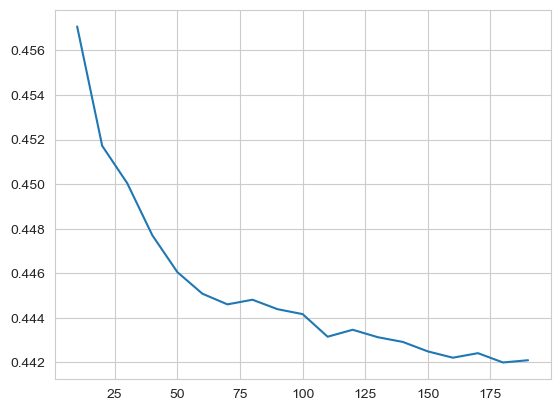

In [30]:
plt.plot(estimators, errors)

### Question 4

In [32]:
estimators = np.arange(10, 200, 10)
depths = [10, 15, 20, 25]
mean_errors = []
for max_depth in depths:
    errors = []
    for est in estimators:
        rf = RandomForestRegressor(max_depth=max_depth, n_estimators=est, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        error = rmse(y_pred, y_val)
        errors.append(error)

    mean_error = np.mean(errors)
    mean_errors.append(mean_error)
    print(f'{max_depth}: {round(mean_error, 3)}')

10: 0.442
15: 0.445
20: 0.446
25: 0.446


### Question 5

In [33]:
rf = RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([1.14536287e-02, 3.96650944e-04, 3.11283259e-04, 3.28170182e-03,
       3.69466267e-04, 3.01551010e-04, 1.60423301e-02, 3.16452511e-03,
       2.33145848e-03, 1.62794233e-03, 4.85137573e-04, 4.93652614e-04,
       5.64584351e-04, 9.59176087e-01])

In [46]:
features = [
    (f[0], f[1])
    for f in zip(list(dv.get_feature_names_out()), rf.feature_importances_)
    if f[0] in ['vehicle_weight', 'horsepower', 'acceleration', 'engine_displacement']
]
features

[('acceleration', np.float64(0.011453628686538216)),
 ('engine_displacement', np.float64(0.00328170182308404)),
 ('horsepower', np.float64(0.01604233007621116)),
 ('vehicle_weight', np.float64(0.9591760874780908))]

In [47]:
max(features, key=lambda f: f[1])

('vehicle_weight', np.float64(0.9591760874780908))

### Question 6

In [50]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [53]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [54]:
for eta in [0.3, 0.1]:
    xgb_params['eta'] = eta
    model = xgb.train(xgb_params, dtrain, num_boost_round=100)
    y_pred = model.predict(dval)
    error = rmse(y_pred, y_val)
    print(f'{eta}: {error}')

0.3: 0.45017755678087246
0.1: 0.42622800553359225
